# **Natural Language Processing with Disaster Tweets**
Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/c/nlp-getting-started

**Context**
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

## Imports & Loading

In [1]:
!pip install -q missingno

In [2]:
!pip install -q pandas==1.2.0

In [3]:
!pip install -q gensim

In [4]:
!pip install -q pyLDAvis==3.2.2

In [5]:
!pip install -q spacy
!python3 -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
!pip install -q nltk

In [7]:
!pip install -q wordcloud

In [8]:
!pip install -q textblob

In [9]:
!pip install -q -U seaborn

In [182]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math
import missingno
import warnings 
import spacy
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [11]:
# Load datasets
train_df = pd.read_csv("train.csv", encoding = "ISO8859-1")
test_df = pd.read_csv("test.csv", encoding = "ISO8859-1")

## **Preprocessing**

### Lower casing

In [12]:
train_df['cleaned']=train_df['text'].apply(lambda x: x.lower())
train_df.head(2)
test_df['cleaned']=test_df['text'].apply(lambda x: x.lower())
test_df.head(2)

,id,keyword,location,text,cleaned
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."


### Remove digits and words containing digits

In [13]:
#train_df['cleaned']=train_df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
#train_df.head(2)

### Remove Punctuations

In [14]:
#train_df['cleaned']=train_df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

### Encoding cleaning

In [15]:
def tweet_cleaner(tweet):
    # Special characters
    tweet = re.sub(r"%20", " ", tweet)
    tweet = re.sub(r"%", " ", tweet)
    tweet = re.sub(r"'", " ", tweet)
    tweet = re.sub(r"\x89û_", " ", tweet)
    tweet = re.sub(r"\x89ûò", " ", tweet)
    tweet = re.sub(r"re\x89û_", " ", tweet)
    tweet = re.sub(r"\x89û", " ", tweet)
    tweet = re.sub(r"\x89Û", " ", tweet)
    tweet = re.sub(r"re\x89Û", "re ", tweet)
    tweet = re.sub(r"re\x89û", "re ", tweet)
    tweet = re.sub(r"\x89ûª", "'", tweet)
    tweet = re.sub(r"\x89û", " ", tweet)
    tweet = re.sub(r"\x89ûò", " ", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)  
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"â", "", tweet)
    tweet = re.sub(r"ã", "", tweet)
    return tweet

train_df['cleaned'] = train_df['cleaned'].apply(lambda x: tweet_cleaner(x))
test_df['cleaned'] = test_df['cleaned'].apply(lambda x: tweet_cleaner(x))

### Expanding contractions
Using dictionary of common English contractions

In [16]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train_df['cleaned']=train_df['cleaned'].apply(lambda x:expand_contractions(x))
train_df.head(2)
test_df['cleaned']=test_df['cleaned'].apply(lambda x:expand_contractions(x))
test_df.head(2)

,id,keyword,location,text,cleaned
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."


In [17]:
# Replace &amp; with &
train_df['cleaned'] = train_df['cleaned'].str.replace('&amp;','&')
test_df['cleaned'] = test_df['cleaned'].str.replace('&amp;','&')

In [18]:
# Remove http / https URLs
train_df['cleaned'] = train_df['cleaned'].str.replace(r'http\S+', '', regex=True)
test_df['cleaned'] = test_df['cleaned'].str.replace(r'http\S+', '', regex=True)

## **EDA**

In [19]:
train_df.head()

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   cleaned   7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


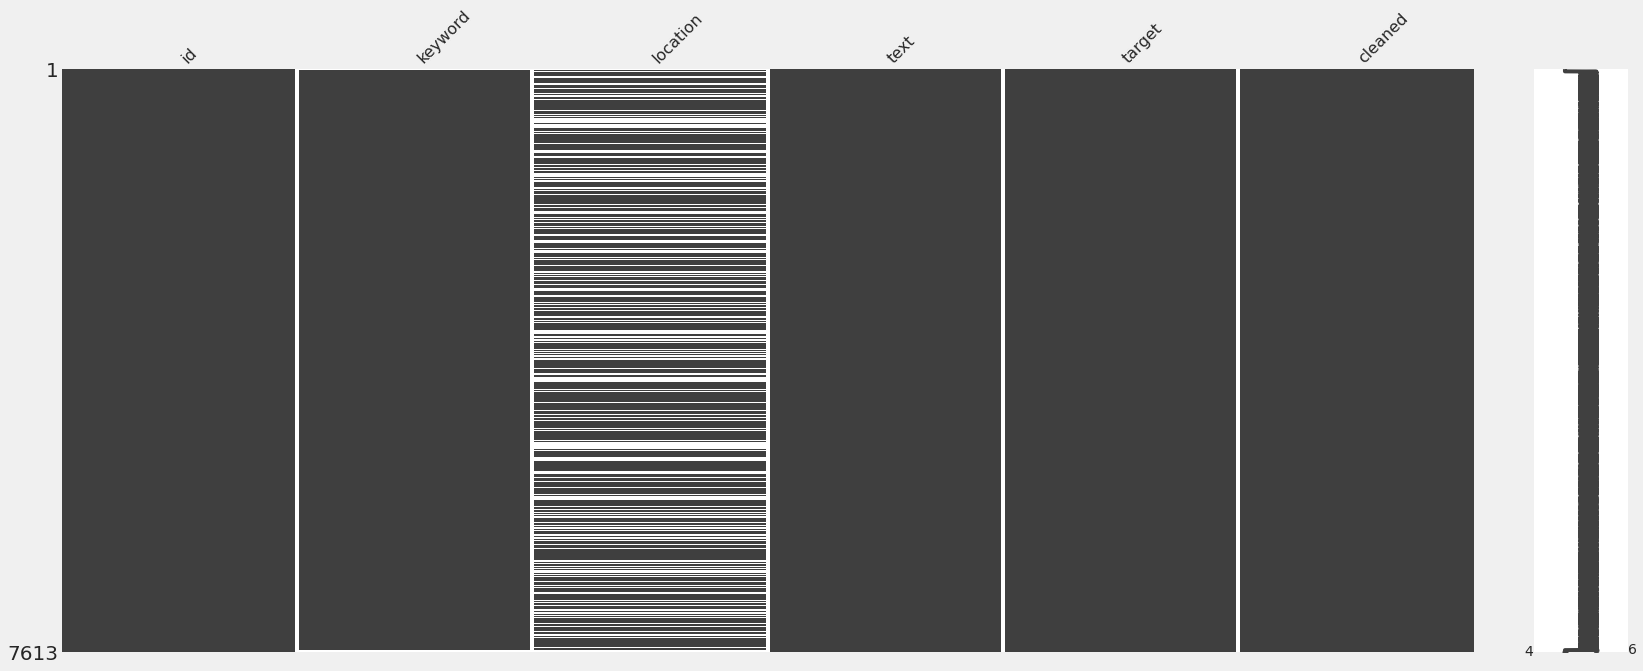

In [21]:
# checking missing data in our dataframe.
missingno.matrix(train_df)

In [22]:
# Get target
target = 'target'

# Get quantitative features and delete the unnccessary features
quantitative = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
quantitative.remove('target')
quantitative.remove('id')

# Get categorical features
categorical = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

,target,id
0,0,4342
1,1,3271


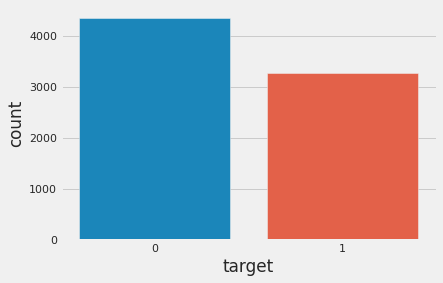

In [23]:
# Now lets see target repartition.
sns.countplot(train_df.target)
train_df.groupby('target').count()['id'].reset_index().sort_values(by='id',ascending=False)



### Histogram of quantitative features

In [24]:
# NOTE : there are no quantitative values here
# f = pd.melt(train_df, value_vars=quantitative)
# g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
# g = g.map(sns.distplot, "value")

### Scatterplot of Quantitative Features against Target


In [25]:
# NOTE : there are no quantitative values here
# f = pd.melt(train_df, id_vars=[target], value_vars=quantitative)
# g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
# g = g.map(sns.regplot, "value", target)

### Countplot of categorical features

In [26]:
#def countplot(x, **kwargs):
#    sns.countplot(x=x)
#    x=plt.xticks(rotation=90)
#f = pd.melt(train_df, value_vars=categorical)
#g = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False, size=5)
#g = g.map(countplot, 'value')

### Box-whisker Plots of Categorical Features against Target

In [27]:
# def boxplot(x, y, **kwargs):
#    sns.boxplot(x=x, y=y)
#    x=plt.xticks(rotation=90)
#f = pd.melt(train, id_vars=[target], value_vars=categorical)
#g = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False, size=5)
#g = g.map(boxplot, 'value', target)

### Correlation matrix of numeric features

In [28]:
# Correlation Matrix

# Compute the correlation matrix
# d= train_df
# corr = d.corr()

# Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, 
#             square=True, linewidths=.5, annot=False, cmap=cmap)
# plt.yticks(rotation=0)
# plt.title('Correlation Matrix of all Numerical Variables')
# plt.show()

### Number of characters

In [29]:
train_df['charcount'] = train_df['cleaned'].str.len()

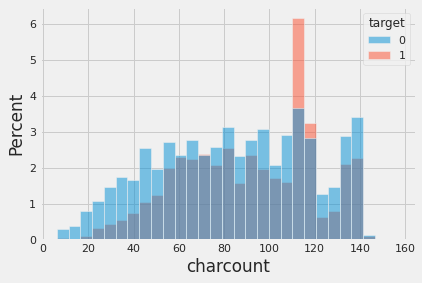

In [30]:
sns.histplot(train_df, x='charcount', stat='percent', hue="target")

### Average word length in sentence

In [31]:
train_df['avgwordlength'] = train_df['cleaned'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x))

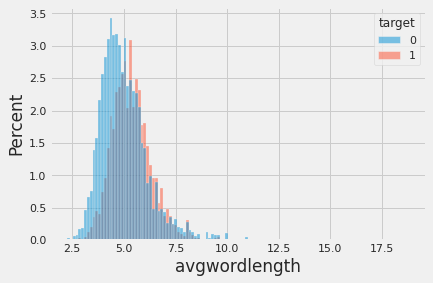

In [32]:
sns.histplot(train_df, x='avgwordlength', stat='percent', hue="target")

### Number of words

In [33]:
train_df['numberofwords'] = train_df['cleaned'].str.split().map(lambda x: len(x))

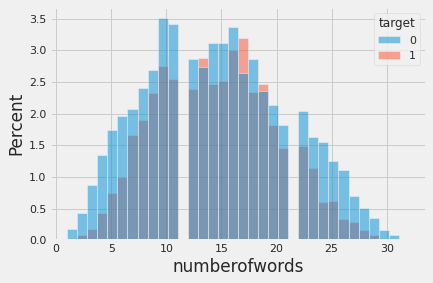

In [34]:
sns.histplot(train_df, x='numberofwords', stat='percent', hue="target")

### Number of each characters

#### Relative values

In [35]:
def count_characters(text):
  result = {}
  text = text.lower()
  # Go through each letter in the text
  for character in text:
      # Add or increment the value in the dictionary
      count = text.count(character)
      result[character] = count
  return result

In [36]:
fulltext_target0 = ''.join(train_df[(train_df.target==0)]['cleaned']).lower()
fulltext_target1 = ''.join(train_df[(train_df.target==1)]['cleaned']).lower()

In [37]:
counter_target0 = Counter(fulltext_target0)
counter_target1 = Counter(fulltext_target1)

In [38]:
counter_percentage_target0 = Counter({key : counter_target0[key] / sum(counter_target0.values()) for key in counter_target1})
counter_percentage_target1 = Counter({key : counter_target1[key] / sum(counter_target1.values()) for key in counter_target1})

In [39]:
counter_percentage_gap={x:(counter_percentage_target0[x]-counter_percentage_target1[x])/(counter_percentage_target1[x]) for x in counter_percentage_target0}
counter_percentage_gap = dict(sorted(counter_percentage_gap.items(), key=lambda item: item[1], reverse=True))

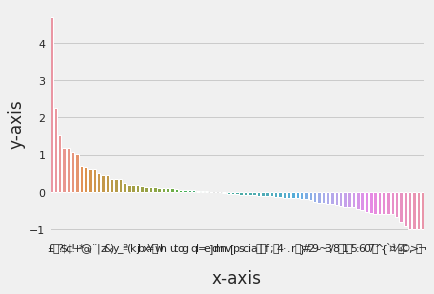

In [40]:
x1,y1=map(list,zip(*counter_percentage_gap.items()))

ax = plt.subplots() 
ax = sns.set(rc={'figure.figsize':(20,8)})
ax = sns.barplot(x1,y1) 

ax.set(xlabel="x-axis", ylabel="y-axis") 
  
plt.show() 

#### Absolute values

In [41]:
counter_target0_sorted_values = dict(sorted(counter_percentage_target0.items(), key=lambda item: item[1], reverse=True))
counter_target0_sorted_keys = dict(sorted(counter_percentage_target0.items()))
counter_target1_sorted_values = dict(sorted(counter_percentage_target1.items(), key=lambda item: item[1], reverse=True))
counter_target1_sorted_keys = dict(sorted(counter_percentage_target1.items()))

In [42]:
characters0_df = pd.DataFrame.from_dict([counter_target0_sorted_keys]).transpose()
characters0_df['target']=0
characters1_df = pd.DataFrame.from_dict([counter_target1_sorted_keys]).transpose()
characters1_df['target']=1
characters_df = characters0_df.append(characters1_df)
characters_df.index.names = ['character']
characters_df.rename(columns={ characters_df.columns[0]: "frequency" }, inplace = True)
characters_df = characters_df.reset_index(level=0)

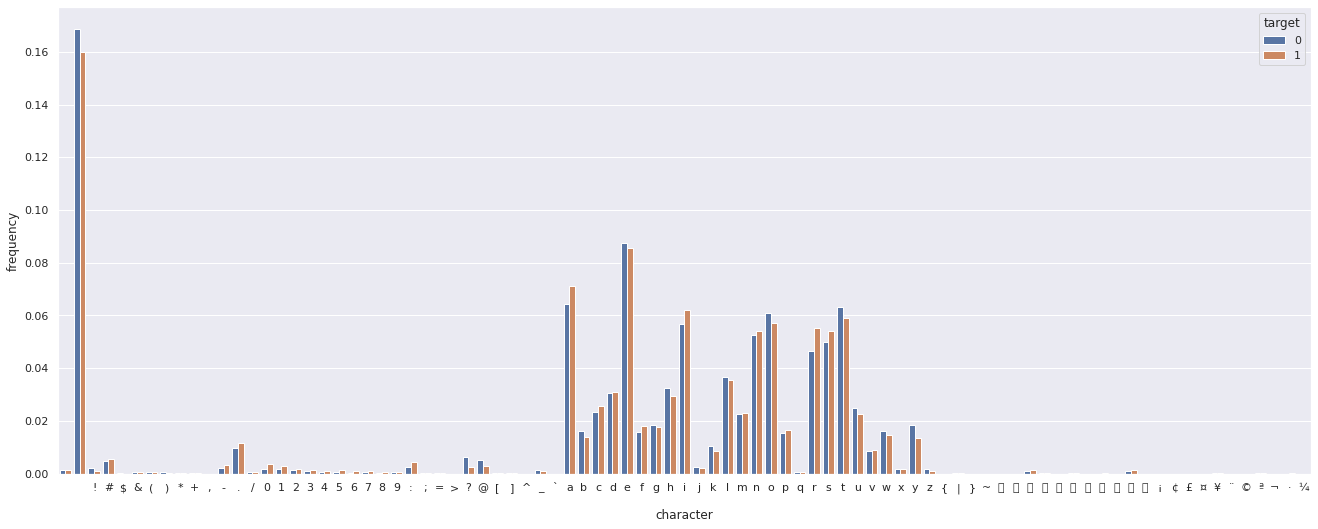

In [43]:
ax=sns.barplot(x='character', y='frequency', data=characters_df, hue='target')
ax = sns.set(rc={'figure.figsize':(20,8)})
plt.show()

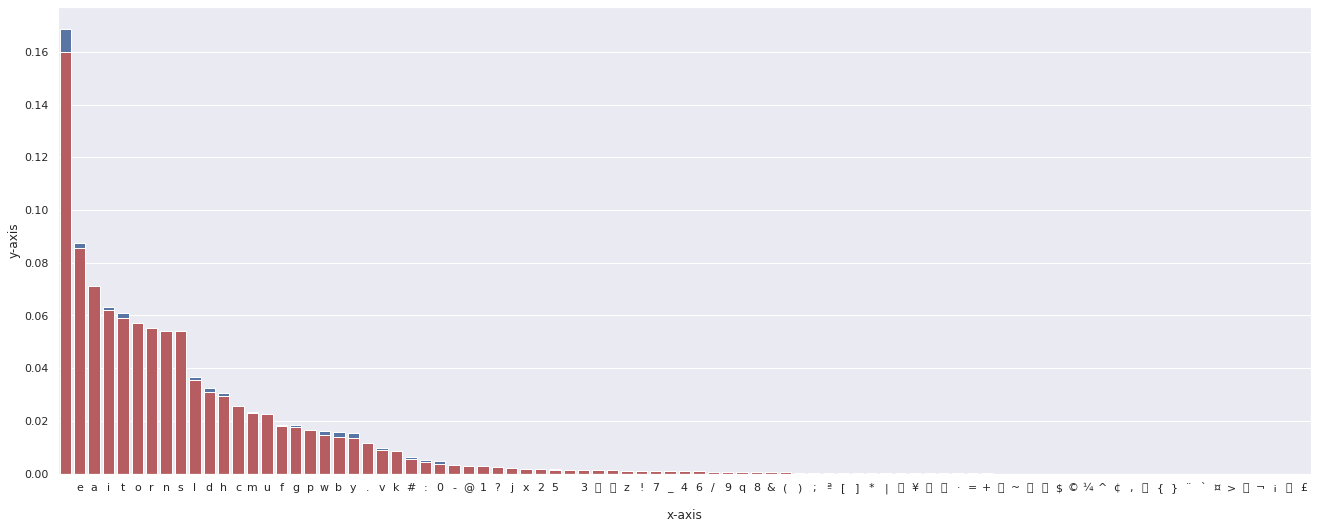

In [44]:
x0,y0=map(list,zip(*counter_target0_sorted_values.items()))
x1,y1=map(list,zip(*counter_target1_sorted_values.items()))

ax = plt.subplots() 
ax = sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x0,y0, color='b') 
ax = sns.barplot(x1,y1, color='r') 

ax.set(xlabel="x-axis", ylabel="y-axis") 
  
plt.show() 

### Top n-grams

In [45]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

#### Top bi-grams

Target == 0

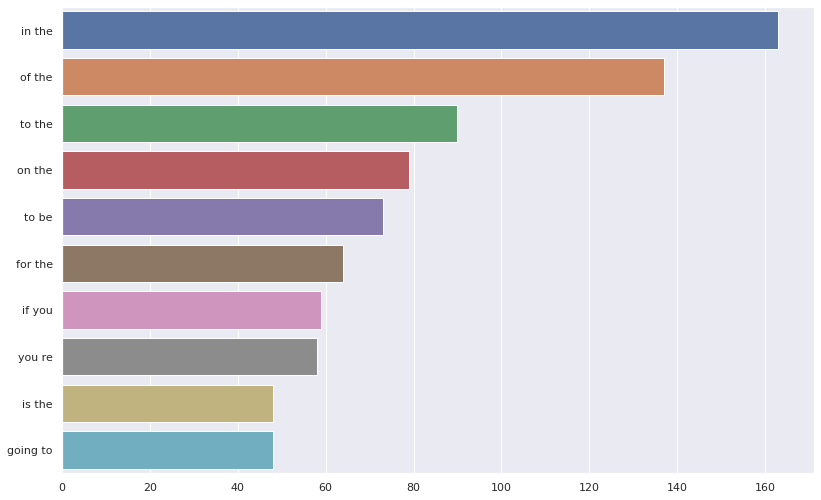

In [46]:
top_n_bigrams=get_top_ngram(train_df[(train_df.target==0)]['cleaned'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x) 

Target == 1

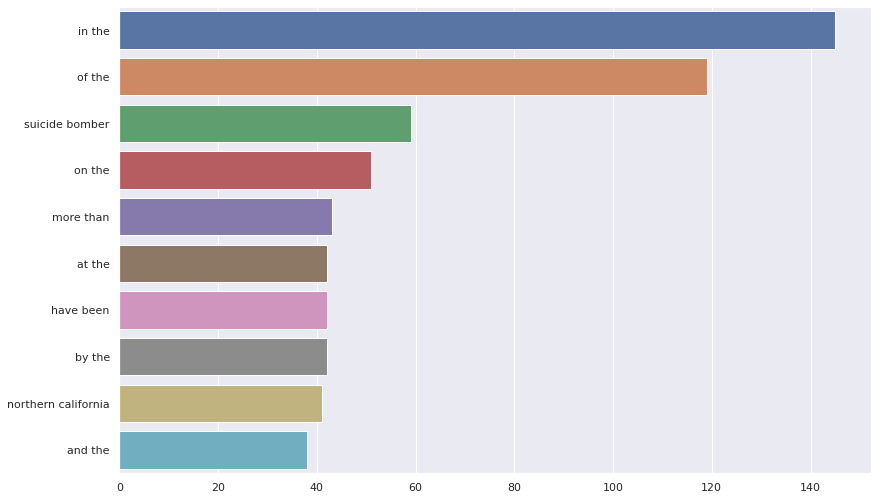

In [47]:
top_n_bigrams=get_top_ngram(train_df[(train_df.target==1)]['cleaned'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x) 

#### Top tri-grams

Target == 0

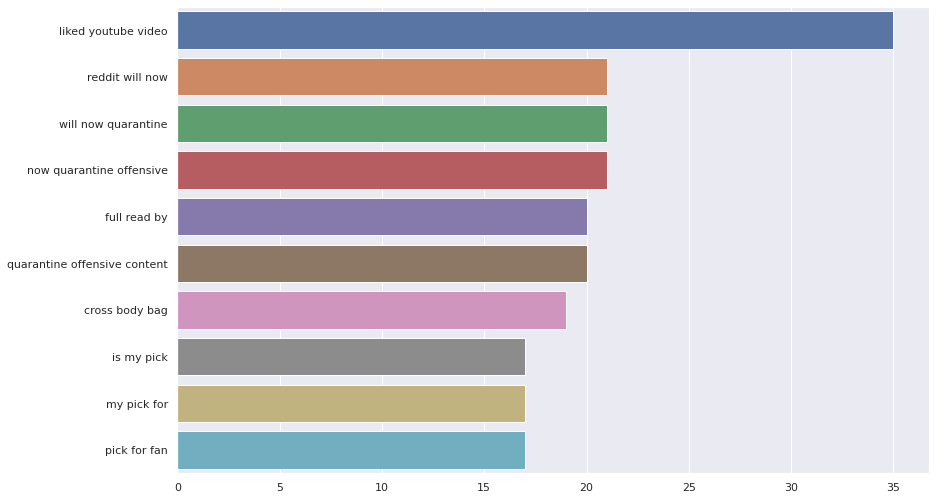

In [48]:
top_tri_grams=get_top_ngram(train_df[(train_df.target==0)]['cleaned'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

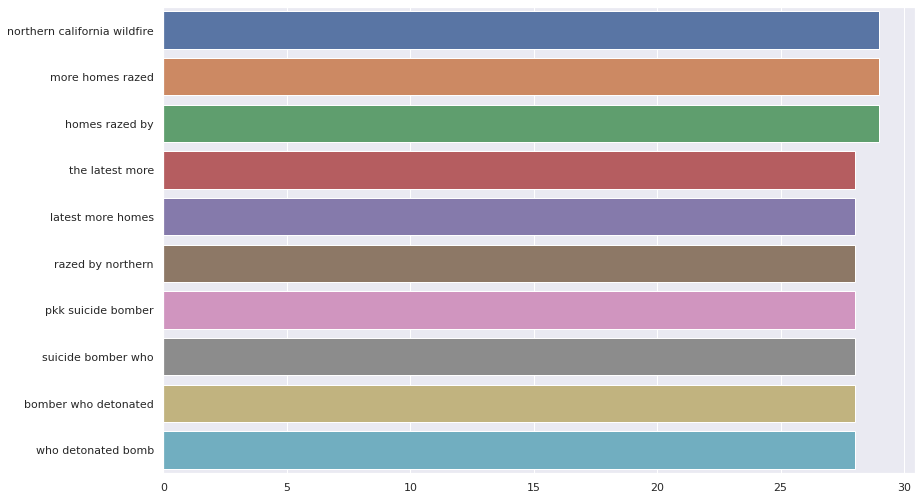

In [49]:
top_tri_grams=get_top_ngram(train_df[(train_df.target==1)]['cleaned'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

### Wordclouds depending on target value

**Target == 0**

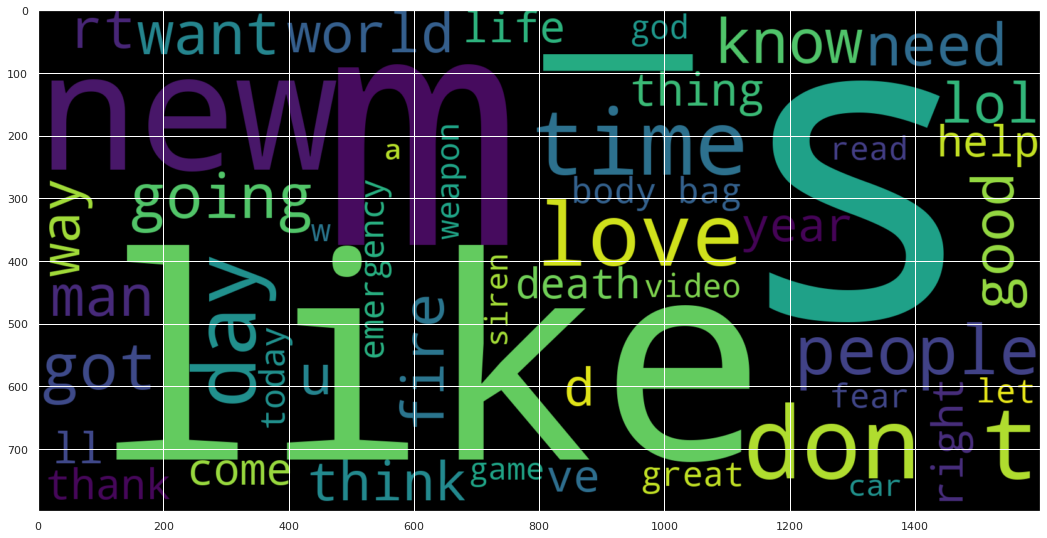

In [50]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 50 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(train_df[(train_df.target==0)]['cleaned'])))
plt.imshow(wc,interpolation = 'bilinear')

**Target == 1**

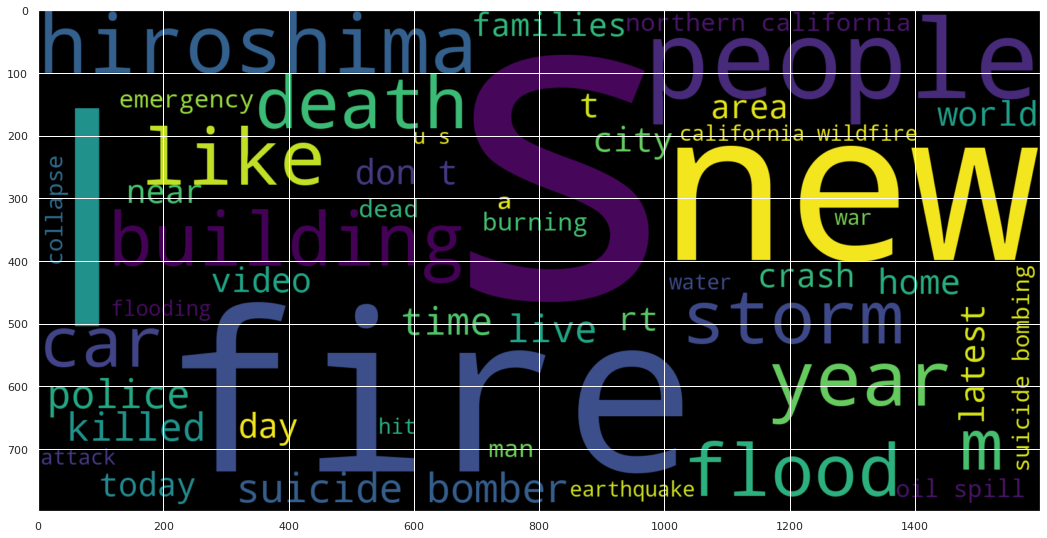

In [51]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 50 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(train_df[(train_df.target==1)]['cleaned'])))
plt.imshow(wc,interpolation = 'bilinear')

### Textblob

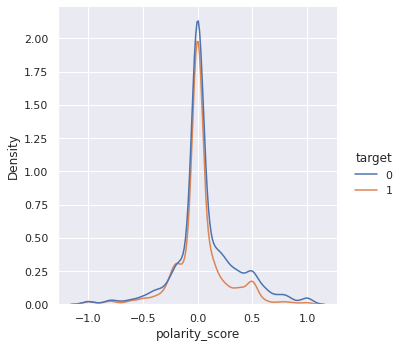

In [52]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

train_df['polarity_score']=train_df['text'].apply(lambda x : polarity(x))
sns.displot(train_df, x='polarity_score', hue="target", kind="kde")

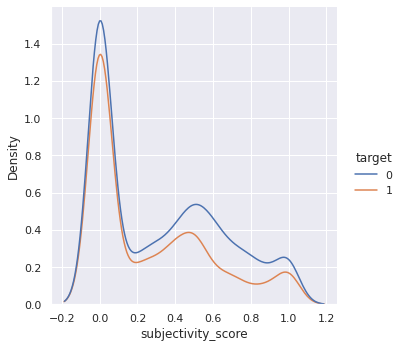

In [53]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

train_df['subjectivity_score']=train_df['text'].apply(lambda x : subjectivity(x))
sns.displot(train_df, x='subjectivity_score', hue="target", kind="kde")

In [54]:
for col in quantitative:
    train_df.boxplot(column=col, by='target', figsize=(6,6))
    plt.title(col)
plt.show()

### VADER

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

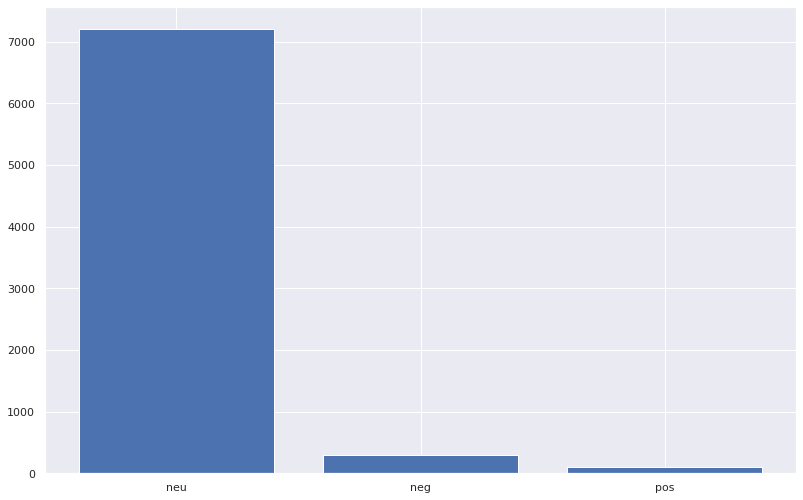

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

train_df['polarity']=train_df['text'].\
    map(lambda x: get_vader_score(x))
polarity=train_df['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

## **Topic modelling**

### Tokenization and lemmatization

In [56]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
corpus=[]
text= train_df['cleaned'].str.split()
text=text.values.tolist()
corpus=[word for i in text for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

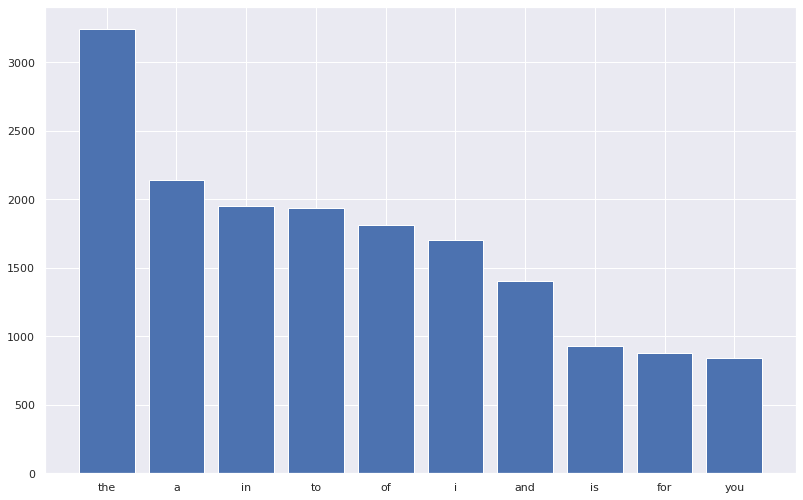

In [58]:
def plot_top_stopwords_barchart(texts):
    stop=set(stopwords.words('english'))
    text= texts.str.split()
    text=text.values.tolist()
    corpus=[word for i in text for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    
plot_top_stopwords_barchart(train_df['cleaned'])

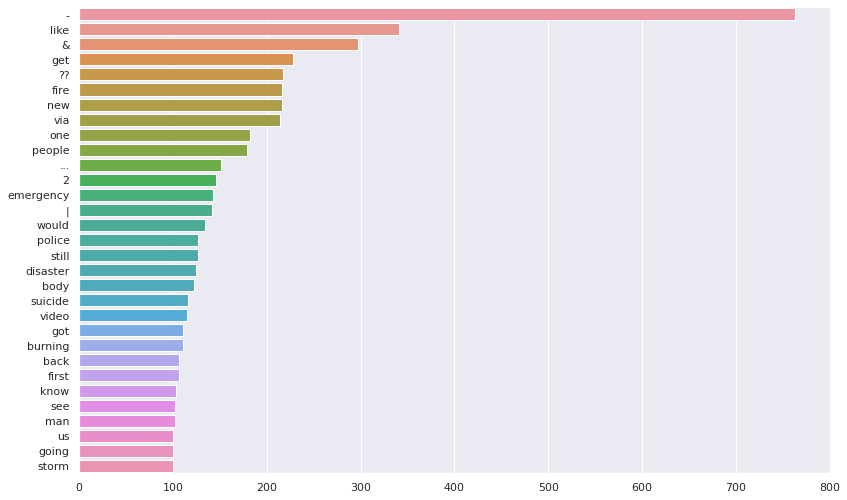

In [59]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

### Lemmatization

In [60]:
# Lemmatization with stopwords removal
train_df['lemmatized']=train_df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [61]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = train_df['cleaned'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']]


In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [63]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.064*"weapon" + 0.043*"go" + 0.027*"wrecked" + 0.022*"think" + 0.021*"rule" + 0.021*"make" + 0.020*"day" + 0.020*"time" + 0.019*"great" + 0.017*"good"'), (1, '0.062*"get" + 0.055*"car" + 0.024*"new" + 0.024*"change" + 0.022*"first" + 0.021*"look" + 0.020*"show" + 0.018*"even" + 0.018*"update" + 0.017*"run"'), (2, '0.000*"wreck_wreck" + 0.000*"northern_marian" + 0.000*"nearby_home" + 0.000*"iger_word" + 0.000*"najibrazak" + 0.000*"lowly" + 0.000*"honor" + 0.000*"hieroglyphic" + 0.000*"king" + 0.000*"bike"'), (3, '0.000*"wreck_wreck" + 0.000*"northern_marian" + 0.000*"nearby_home" + 0.000*"iger_word" + 0.000*"najibrazak" + 0.000*"lowly" + 0.000*"honor" + 0.000*"hieroglyphic" + 0.000*"king" + 0.000*"bike"'), (4, '0.169*"wreck" + 0.065*"family" + 0.032*"fire" + 0.030*"say" + 0.028*"watch" + 0.026*"dead" + 0.021*"exchanging_shot" + 0.019*"people" + 0.015*"earthquake" + 0.015*"wreckage"'), (5, '0.000*"wreck_wreck" + 0.000*"northern_marian" + 0.000*"nearby_home" + 0.000*"iger_word" + 0

In [64]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5052,"weapon, go, wrecked, think, rule, make, day, t...","[deed, reason, earthquake, forgive]"
1,1,4.0,0.5733,"wreck, family, fire, say, watch, dead, exchang...","[forest, fire]"
2,2,6.0,0.3583,"kill, late, still, police, wildfire, break, pi...","[resident, ask, shelter, place, notify, office..."
3,3,6.0,0.5158,"kill, late, still, police, wildfire, break, pi...","[people, receive, wildfire, evacuation, order]"
4,4,1.0,0.2666,"get, car, new, change, first, look, show, even...","[get, send, photo, alaska, smoke, wildfire, po..."
5,5,6.0,0.3165,"kill, late, still, police, wildfire, break, pi...","[rockyfire, update, direction, due, lake, coun..."
6,6,7.0,0.3465,"wound, news, see, help, suffer, world, storm, ...","[flood, disaster, heavy_rain, cause, flash, fl..."
7,7,4.0,0.5241,"wreck, family, fire, say, watch, dead, exchang...","[see, fire, wood]"
8,8,4.0,0.2311,"wreck, family, fire, say, watch, dead, exchang...","[emergency, evacuation, happen, building, street]"
9,9,9.0,0.3680,"train, word, whirlwind, life, part, love, wind...","[afraid, come, area]"


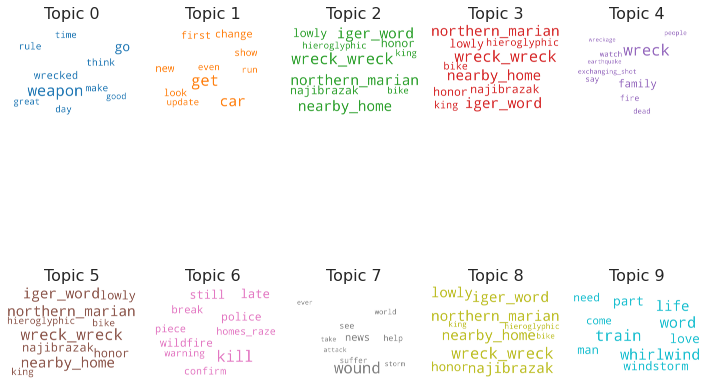

In [65]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [66]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5760 samples in 0.007s...
[t-SNE] Computed neighbors for 5760 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5760
[t-SNE] Computed conditional probabilities for sample 2000 / 5760
[t-SNE] Computed conditional probabilities for sample 3000 / 5760
[t-SNE] Computed conditional probabilities for sample 4000 / 5760
[t-SNE] Computed conditional probabilities for sample 5000 / 5760
[t-SNE] Computed conditional probabilities for sample 5760 / 5760
[t-SNE] Mean sigma: 0.000040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.930984
[t-SNE] KL divergence after 1000 iterations: 0.575341


Loading BokehJS ...

In [67]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds') # essayer avec mmds
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.359717 -0.174265       1        1  17.357075
4      0.346158  0.159951       2        1  16.474702
9     -0.272246  0.268845       3        1  15.777856
1      0.050903 -0.370500       4        1  15.259411
7      0.318109 -0.157977       5        1  14.208934
6      0.075861  0.348147       6        1  12.643165
3     -0.039767 -0.018549       7        1   2.069715
5     -0.039767 -0.018551       8        1   2.069714
2     -0.039767 -0.018550       9        1   2.069714
8     -0.039767 -0.018550      10        1   2.069714, topic_info=            Term         Freq        Total Category  logprob  loglift
461        wreck  1244.000000  1244.000000  Default  30.0000  30.0000
1867       wound   808.000000   808.000000  Default  29.0000  29.0000
1099      weapon   501.000000   501.000000  Default  28.0000  28.0000
436       family   478.000000   478.000000  Default  27.0000  27.0000
19           get   421.000000   421.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3907   malaysian     0.107656     1.472773  Topic10  -9.0603   1.2618
8587     nervous     0.107647     1.462713  Topic10  -9.0604   1.2686
8577  fitzgerald     0.107640     1.465636  Topic10  -9.0605   1.2665
2493     explode     0.107636    32.226086  Topic10  -9.0605  -1.8240
8445   wild_fire     0.107633   244.986435  Topic10  -9.0605  -3.8525

[448 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
346       2  0.981403     also
1767      2  0.990225      app
32        6  0.978970     area
695       5  0.993978   attack
290       1  0.995005     back
...     ...       ...      ...
8593      3  0.141000  wrecked
8593      4  0.039167  wrecked
396       6  0.965655    wrong
148       4  0.989981     year
390       1  0.984716  youtube

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 10, 2, 8, 7, 4, 6, 3, 9])

### Tokenization

In [137]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(train_df["cleaned"])
vocab_length = len(tokenizer.word_index) + 1
train_df["tweet_encoded"] = tokenizer.texts_to_sequences(train_df["cleaned"])

In [146]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return tokenizer.texts_to_sequences(corpus)

In [139]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [147]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
longest_train = max(train_df['cleaned'], key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(
    embed(train_df['cleaned']),
    length_long_sentence,
    padding='post')
test_sentences = pad_sequences(
    embed(test_df['cleaned']), 
    length_long_sentence,
    padding='post')

In [164]:
full_ds = tf.data.Dataset.from_tensor_slices((padded_sentences, train_df['target']))

In [165]:
# Train Test Split
TAKE_SIZE = int(0.7*train_df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [150]:
 # Regardons un batch 
for tweet, target in train_data.take(1):
    print(tweet, target)

tf.Tensor(
[[  8   2 905 ...   0   0   0]
 [  9 162   0 ...   0   0   0]
 [109 203   7 ...   0   0   0]
 ...
 [212 967 493 ...   0   0   0]
 [201  42 579 ...   0   0   0]
 [803   8  14 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1
 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0], shape=(64,), dtype=int64)


In [189]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(min_delta=0.001,patience=10)

Simple model

In [205]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length,16,input_length = length_long_sentence),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 72, 16)            277616    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 7         
Total params: 277,725
Trainable params: 277,725
Non-trainable params: 0
_________________________________________________________________


In [206]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/20
84/84 [==============================] - 1s 6ms/step - loss: 0.6874 - accuracy: 0.5637 - val_loss: 0.6856 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.5755 - val_loss: 0.6835 - val_accuracy: 0.5582
Epoch 3/20
84/84 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.5755 - val_loss: 0.6815 - val_accuracy: 0.5582
Epoch 4/20
84/84 [==============================] - 0s 6ms/step - loss: 0.6715 - accuracy: 0.5755 - val_loss: 0.6749 - val_accuracy: 0.5582
Epoch 5/20
84/84 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.5755 - val_loss: 0.6653 - val_accuracy: 0.5582
Epoch 6/20
84/84 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.5755 - val_loss: 0.6417 - val_accuracy: 0.5582
Epoch 7/20
84/84 [==============================] - 0s 6ms/step - loss: 0.6160 - accuracy: 0.6087 - val_loss: 0.6219 - val_accuracy: 0.6484
Epoch 8/20
84/84 [==

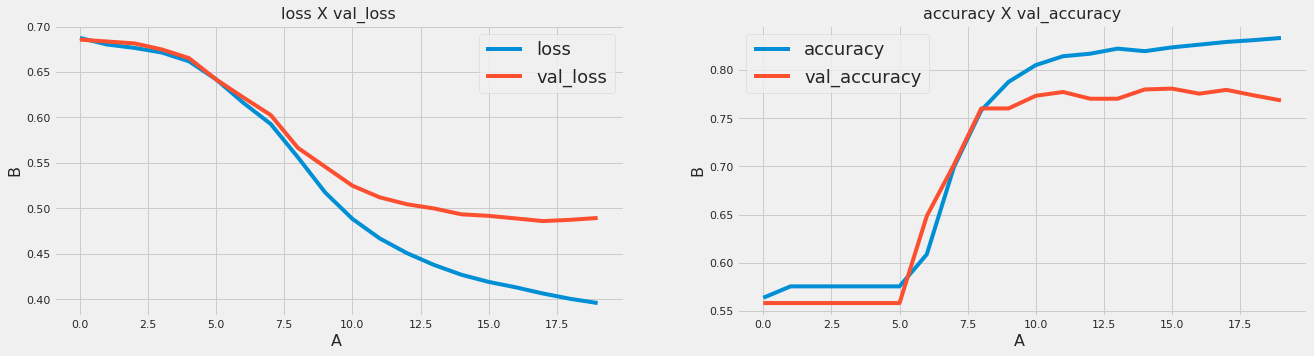

In [207]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

2nd model

In [212]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_length,16,input_length = length_long_sentence))
model.add(tf.keras.layers.LSTM(128,activation='relu',return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D(),)
model.add(tf.keras.layers.Dense(6, activation = "relu"))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.add(tf.keras.layers.Dense(4,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 72, 16)            277616    
_________________________________________________________________
lstm_13 (LSTM)               (None, 72, 128)           74240     
_________________________________________________________________
global_average_pooling1d_10  (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 7         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 8         
Total params: 352,645
Trainable params: 352,645
Non-trainable params: 0
_______________________________________________

In [213]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/20
84/84 [==============================] - 11s 130ms/step - loss: 0.7889 - accuracy: 0.5755 - val_loss: 0.7976 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 10s 122ms/step - loss: 0.7706 - accuracy: 0.5755 - val_loss: 0.7840 - val_accuracy: 0.5582
Epoch 3/20
84/84 [==============================] - 10s 121ms/step - loss: 0.7611 - accuracy: 0.5755 - val_loss: 0.7774 - val_accuracy: 0.5582
Epoch 4/20
84/84 [==============================] - 10s 122ms/step - loss: 0.7567 - accuracy: 0.5755 - val_loss: 0.7746 - val_accuracy: 0.5582
Epoch 5/20
84/84 [==============================] - 10s 122ms/step - loss: 0.7549 - accuracy: 0.5755 - val_loss: 0.7735 - val_accuracy: 0.5582
Epoch 6/20
84/84 [==============================] - 11s 132ms/step - loss: 0.7543 - accuracy: 0.5755 - val_loss: 0.7732 - val_accuracy: 0.5582
Epoch 7/20
84/84 [==============================] - 11s 128ms/step - loss: 0.7541 - accuracy: 0.5755 - val_loss: 0.7730 - val_accuracy: 0.5582

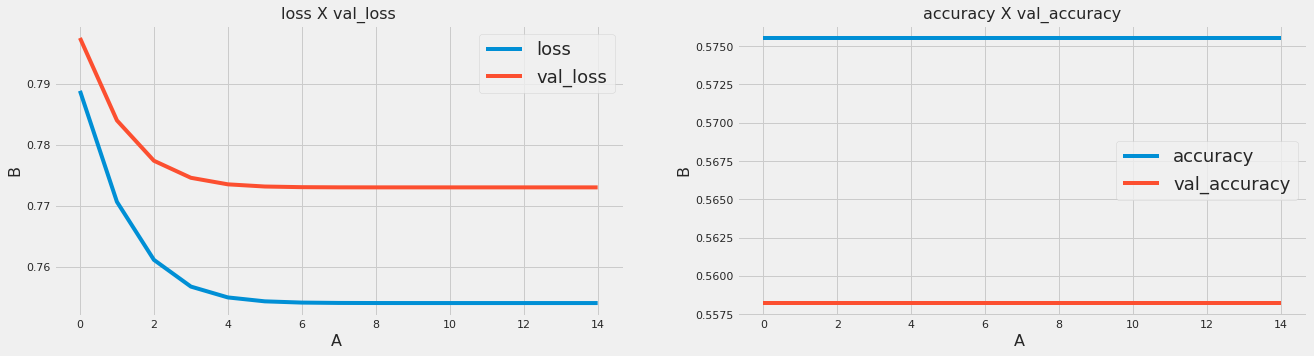

In [214]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

Complex model

In [191]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length,16,input_length=length_long_sentence),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(18,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(9,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 72, 16)            277616    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 72, 32)            4224      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_30 (Dense)             (None, 18)                594       
_________________________________________________________________
dropout_6 (Dropout)          (None, 18)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 18)                72        
_________________________________________________________________
dense_31 (Dense)             (None, 9)               

In [192]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/20
84/84 [==============================] - 10s 114ms/step - loss: 0.7417 - accuracy: 0.5494 - val_loss: 0.6825 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 8s 96ms/step - loss: 0.5251 - accuracy: 0.7416 - val_loss: 0.6602 - val_accuracy: 0.5757
Epoch 3/20
84/84 [==============================] - 8s 95ms/step - loss: 0.4695 - accuracy: 0.7883 - val_loss: 0.6261 - val_accuracy: 0.7815
Epoch 4/20
84/84 [==============================] - 8s 96ms/step - loss: 0.4364 - accuracy: 0.8215 - val_loss: 0.5943 - val_accuracy: 0.7644
Epoch 5/20
84/84 [==============================] - 8s 93ms/step - loss: 0.4155 - accuracy: 0.8257 - val_loss: 0.5673 - val_accuracy: 0.7093
Epoch 6/20
84/84 [==============================] - 8s 97ms/step - loss: 0.3983 - accuracy: 0.8388 - val_loss: 0.5339 - val_accuracy: 0.7412
Epoch 7/20
84/84 [==============================] - 8s 98ms/step - loss: 0.3830 - accuracy: 0.8409 - val_loss: 0.6449 - val_accuracy: 0.6112
Epoch 8/20


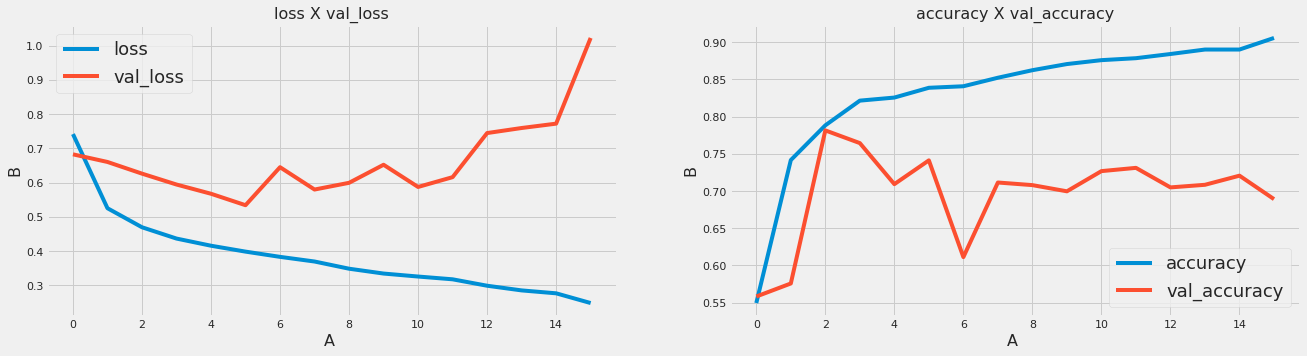

In [193]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

## **Sample model (Tutorial)**
Let's look at our data... first, an example of what is NOT a disaster tweet.

In [68]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [69]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [70]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [71]:
print(example_train_vectors[0])

  (0, 34)	1
  (0, 12)	1
  (0, 5)	1
  (0, 49)	1
  (0, 39)	1
  (0, 29)	1
  (0, 50)	1
  (0, 13)	1
  (0, 25)	1
  (0, 4)	1
  (0, 18)	1
  (0, 52)	1
  (0, 3)	1


In [72]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [73]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [74]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [75]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59056806, 0.57030867, 0.64176904])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [76]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

## Submission

In [77]:
sample_submission = pd.read_csv("sample_submission.csv")

In [78]:
sample_submission["target"] = clf.predict(test_vectors)

In [79]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [80]:
sample_submission.to_csv("submission.csv", index=False)